In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
MODEL_NAME = "FastFastRICH_Cramer_All_meta"
PARTICLES = ['kaon', 'pion', 'proton', 'muon', 'electron']

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import scipy
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

Using TensorFlow backend.


In [4]:
import rich_utils.utils_rich_mrartemev as utils_rich

In [5]:
gpu_options = tf.GPUOptions(allow_growth=True)
tf_config = tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options)

In [7]:
data_train, data_val, scalers = utils_rich.get_all_particles_dataset(dtype=np.float32, log=True)

Reading and concatenating datasets:
	../data/data_calibsample/kaon_-_up_2016_.csv
	../data/data_calibsample/kaon2_-_down_2016_.csv
	../data/data_calibsample/kaon2_+_down_2016_.csv
	../data/data_calibsample/kaon_-_down_2016_.csv
	../data/data_calibsample/kaon_+_down_2016_.csv
	../data/data_calibsample/kaon2_+_up_2016_.csv
	../data/data_calibsample/kaon_+_up_2016_.csv
	../data/data_calibsample/kaon2_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.940828561782837
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
Reading and concatenating datasets:
	../data/data_calibsample/pion2_-_down_2016_.csv
	../data/data_calibsample/pion_-_up_2016_.csv
	../data/data_calibsample/pion2_-_up_2016_.csv
	../data/data_calibsample/pion_+_up_2016_.csv
	../data/data_calibsample/pion2_+_up_2016_.csv
	../data/data_calibsample/pion2_+_down_2016_.csv
	../data/data_calibsample/pion_-_down_2016_.csv
	..

In [8]:
BATCH_SIZE = int(5e4)
LATENT_DIMENSIONS = 64
tf.reset_default_graph()

In [9]:
train_full_ = utils_rich.get_tf_dataset(data_train, BATCH_SIZE)
train_x_1_  = utils_rich.get_tf_dataset(data_train.values[:, utils_rich.y_count:], BATCH_SIZE)
train_x_2_  = utils_rich.get_tf_dataset(data_train.values[:, utils_rich.y_count:], BATCH_SIZE)

train_full, w_full = train_full_[:,:-1], train_full_[:,-1]
train_x_1 , w_x_1  = train_x_1_ [:,:-1], train_x_1_ [:,-1]
train_x_2 , w_x_2  = train_x_2_ [:,:-1], train_x_2_ [:,-1]

In [10]:
CRAMER_DIM = 256
NUM_LAYERS = 5

def get_dense(num_layers):
    return [ll.Dense(128, activation='relu') for i in range(num_layers)]

def get_critic(num_layers):
    return keras.models.Sequential(
        [ll.InputLayer([data_train.shape[1] - 1])] +
        get_dense(num_layers) + 
        [ll.Dense(CRAMER_DIM)])

def get_generator(num_layers):
    return keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count])] + 
        get_dense(num_layers) + 
        [ll.Dense(utils_rich.y_count)])

critic = get_critic(NUM_LAYERS)
generator = get_generator(NUM_LAYERS)

In [11]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [12]:
noise_1 = tf.random_normal([tf.shape(train_x_1)[0], LATENT_DIMENSIONS], name='noise')
noise_2 = tf.random_normal([tf.shape(train_x_2)[0], LATENT_DIMENSIONS], name='noise')
generated_y_1 = generator(tf.concat([noise_1, train_x_1], axis=1))
generated_full_1 = tf.concat([generated_y_1, train_x_1], axis=1)
generated_y_2 = generator(tf.concat([noise_2, train_x_2], axis=1))
generated_full_2 = tf.concat([generated_y_2, train_x_2], axis=1)

In [13]:
generator_loss = tf.reduce_mean(cramer_critic(train_full, generated_full_2) * w_full * w_x_2 -
                                cramer_critic(generated_full_1, generated_full_2) * w_x_1  * w_x_2)

In [14]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(train_full)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*train_full + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [15]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(1e-3, tf_iter, 200, 0.98)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

In [16]:
critic_loss_summary = tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
generator_loss_summary = tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
lr_summary = tf.summary.scalar("learning_rate", learning_rate)
lambda_summary = tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge([critic_loss_summary, generator_loss_summary, lr_summary, lambda_summary])


In [17]:
N_VAL = int(5e4)
validation_set = {particle: data_val[data_val['is_{}'.format(particle)] == 1].sample(N_VAL).values for particle in PARTICLES}


In [18]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()
tf.get_default_graph().finalize()

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
LOGDIR = "tensorboard_logdir/"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(1e5) * 5
VALIDATION_INTERVAL = 1000
MODEL_WEIGHTS_FILE = "weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS
)

particle: kaon, epoch: 220000


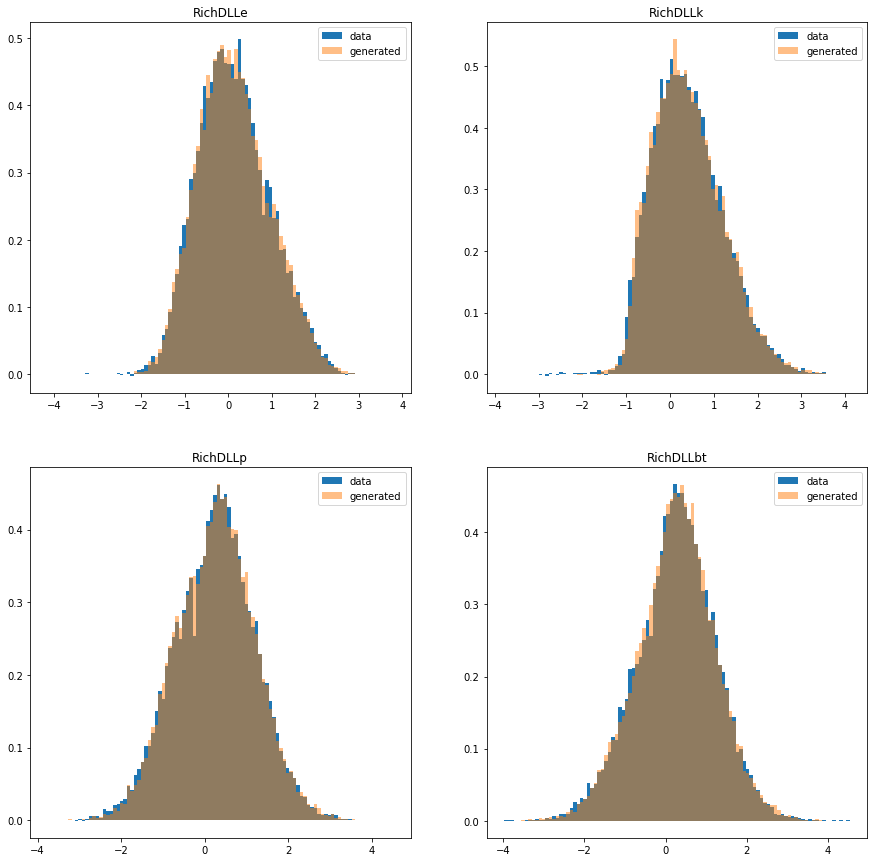

particle: pion, epoch: 220000


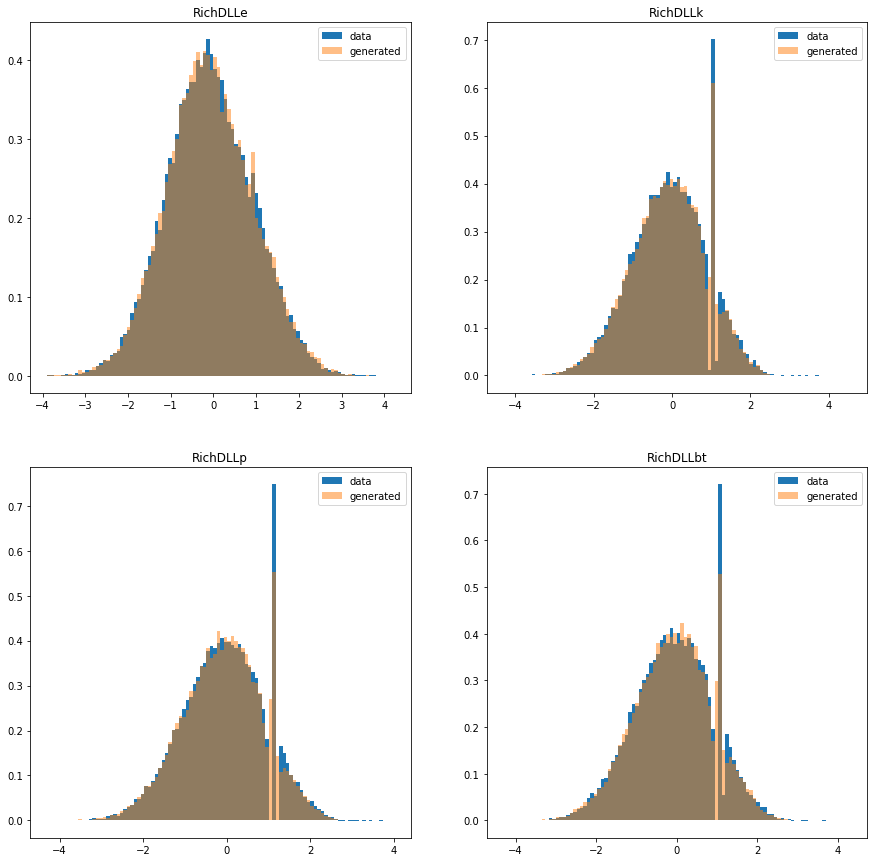

particle: proton, epoch: 220000


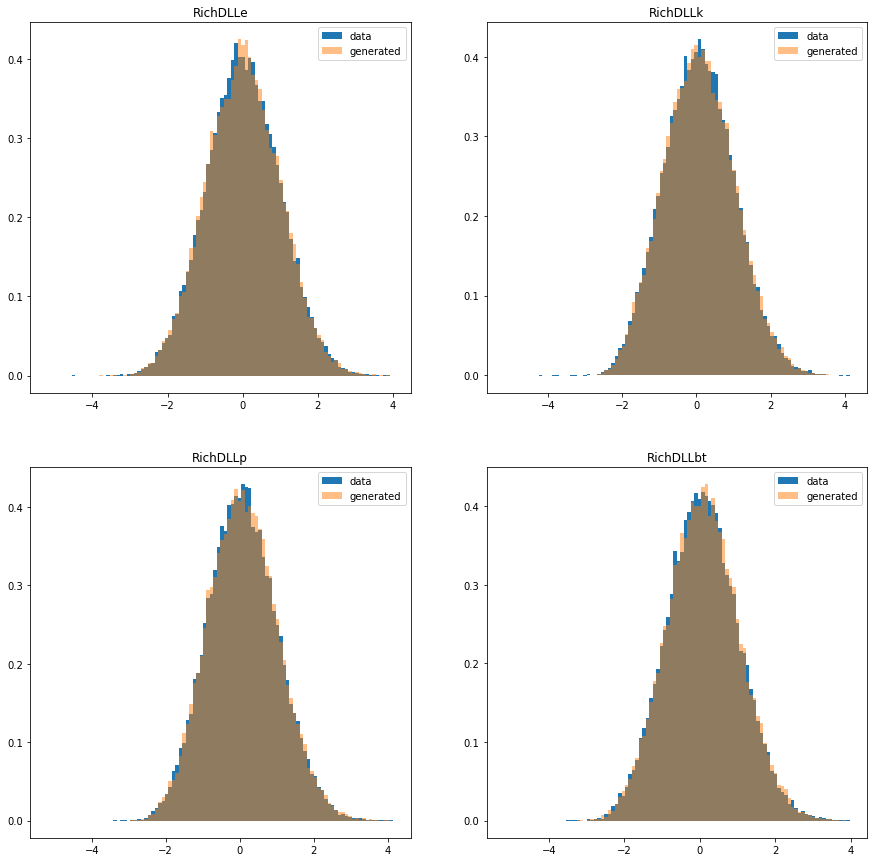

particle: muon, epoch: 220000


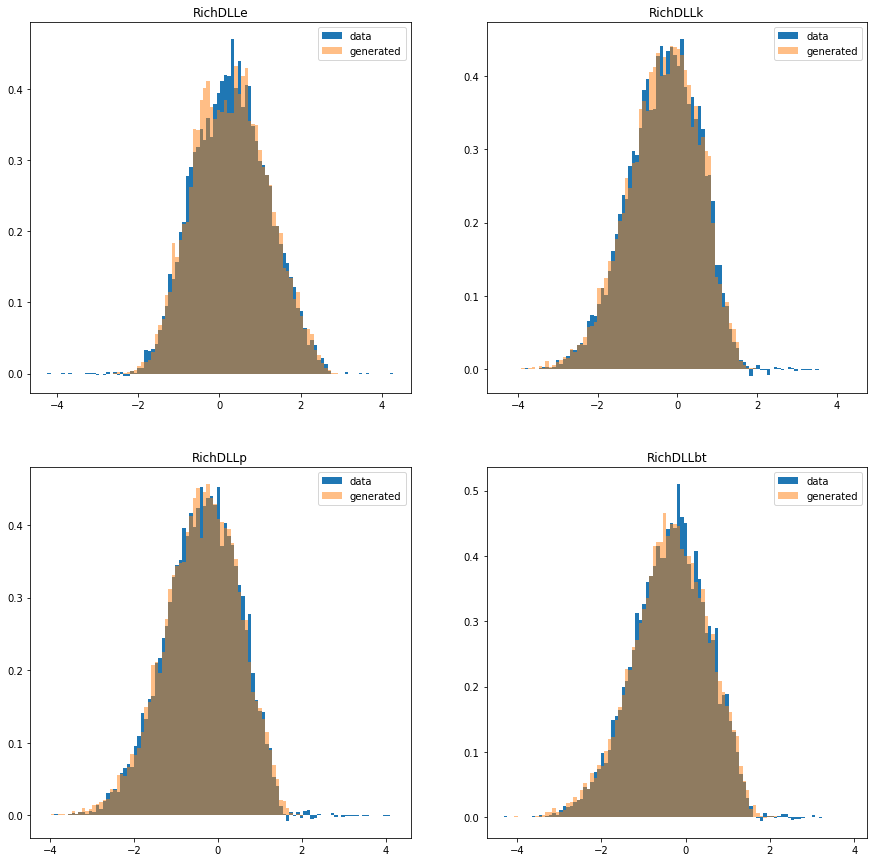

particle: electron, epoch: 220000


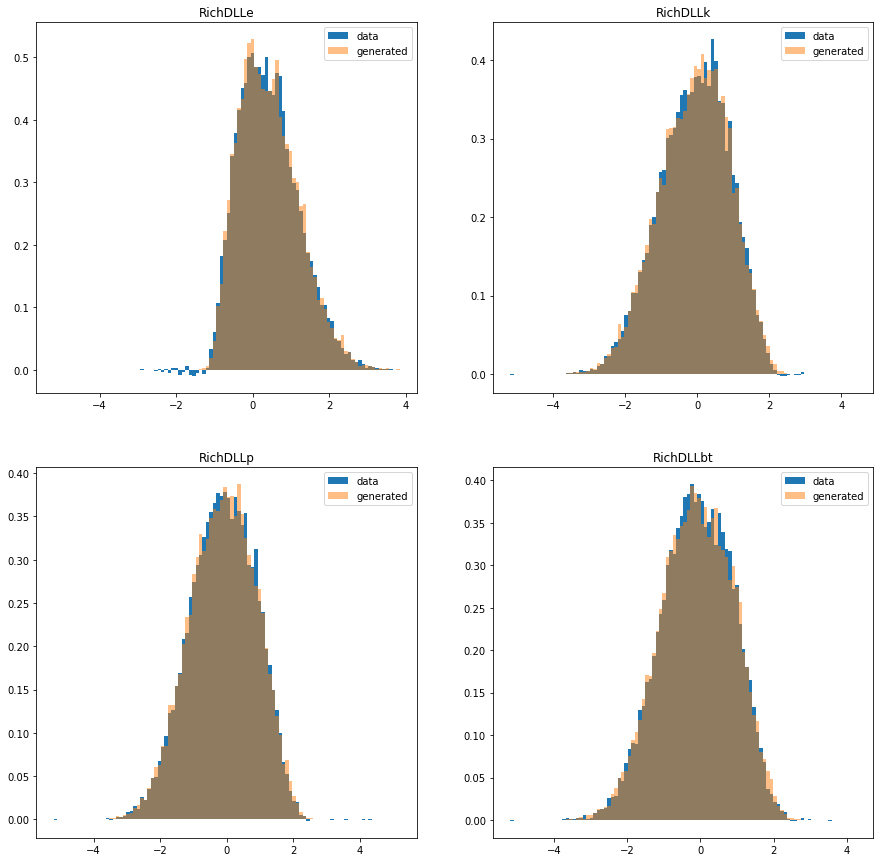

 34%|███▍      | 135282/400001 [143:04:43<270:19:46,  3.68s/it] 

KeyboardInterrupt: 

In [21]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except (ValueError, tf.errors.NotFoundError) :
        print("Can't restore parameters: no file with weights")
    for i in tqdm(range(99999, TOTAL_ITERATIONS)):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, iteration = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, iteration)
        if i % VALIDATION_INTERVAL == 0:
            clear_output(False)
            for ind, particle in enumerate(PARTICLES):
                print('particle: {}, epoch: {}'.format(particle, i))
                validation_np = validation_set[particle]
                test_summary, test_generated = sess.run([merged_summary, generated_y_1], {
                    train_x_1_: validation_np[:, utils_rich.y_count:],
                    train_x_2_: validation_np[:, utils_rich.y_count:], train_full_: validation_np})
                test_writer.add_summary(test_summary, iteration)
                weights_saver.save(sess, MODEL_WEIGHTS_FILE)
                fig, axes = plt.subplots(2, 2, figsize=(15, 15))
                for INDEX, ax in zip((0, 1, 3, 4), axes.flatten()):
                    _, bins, _ = ax.hist(validation_np[:, INDEX], bins=100, label="data", normed=True,
                                         weights=validation_np[:,-1])
                    ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, normed=True,
                            weights=validation_np[:,-1])
                    ax.legend()
                    ax.set_title(utils_rich.dll_columns[INDEX])
                plt.show()


In [23]:
MODEL_NAME = 'FastFastRICH_Cramer_All_meta_5_layers'

In [24]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    sess.graph._unsafe_unfinalize()
    tf.saved_model.simple_save(sess, os.path.join(
        "exported_model", MODEL_NAME), inputs={"x": train_x_1_}, outputs={"dlls": generated_y_1})
    tf.get_default_graph().finalize()

INFO:tensorflow:Restoring parameters from weights/FastFastRICH_Cramer_All_meta.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: exported_model/FastFastRICH_Cramer_All_meta_5_layers/saved_model.pb


In [25]:
from sklearn.externals import joblib

MODEL_PREPROCESSORS_PATH = os.path.join('preprocessors', MODEL_NAME)

os.makedirs(MODEL_PREPROCESSORS_PATH, exist_ok=True)

for ind, particle in enumerate(PARTICLES):
    joblib.dump(scalers[ind], os.path.join(MODEL_PREPROCESSORS_PATH, "{}_preprocessor.pkl".format(particle)))

In [26]:
import warnings
import os, sys
from rich_utils import make_prediction, model_testing
import pandas as pd

warnings.simplefilter('ignore')

data = make_prediction.load_all_and_predict(
        models_path = 'exported_model',
        preprocessors_path = 'preprocessors',
        model_name_format = MODEL_NAME,
        preprocessor_name_format = MODEL_NAME + "/{}_preprocessor.pkl",
        tf_config = tf_config,
        output_filename = None
    )




INFO:tensorflow:Restoring parameters from exported_model/FastFastRICH_Cramer_All_meta_5_layers/variables/variables
exported_model/FastFastRICH_Cramer_All_meta_5_layers
exported_model/FastFastRICH_Cramer_All_meta_5_layers
exported_model/FastFastRICH_Cramer_All_meta_5_layers
exported_model/FastFastRICH_Cramer_All_meta_5_layers
exported_model/FastFastRICH_Cramer_All_meta_5_layers


In [27]:
def eval_model(particle, data):
    params = dict(
        max_depth=5,
        n_estimators=200,
        learning_rate=0.1,
        min_child_weight=50,
        n_jobs=24
    )
    selection_funcs, bins = \
        model_testing.make_nd_bin_selection(('Brunel_P', [0., 10000., 50000., 1000000.]),
                                            ('Brunel_ETA', [2., 3., 3.5, 5.]),
                                            ('nTracks_Brunel', [0, 150, 250, 1000]))
    if particle == 'electron':
        selection_funcs, bins = \
            model_testing.make_nd_bin_selection(('Brunel_P', [0., 10000., 50000.]),
                                                ('Brunel_ETA', [2., 3., 3.5,]),
                                                )
    scores = model_testing.kfold_test(model_testing.merge_dataframes(data[particle].test),
                                      params, selection_funcs=selection_funcs)
    return scores, bins

In [28]:
particle_scores = {}

for ind, particle in enumerate(PARTICLES):
    particle_scores[ind] = eval_model(particle, data)


100%|██████████| 3/3 [03:37<00:00, 72.63s/it]

100%|██████████| 3/3 [03:42<00:00, 74.53s/it]

100%|██████████| 3/3 [02:14<00:00, 45.05s/it]

100%|██████████| 3/3 [01:58<00:00, 39.64s/it]

100%|██████████| 3/3 [01:32<00:00, 30.94s/it]


In [29]:
for ind, particle in enumerate(PARTICLES):
    print("Particle: {}, global test score: {}".format(particle, particle_scores[ind][0].mean(axis=0)[0][1]))

Particle: kaon, global test score: 0.9423327142469993
Particle: pion, global test score: 0.9907804464210689
Particle: proton, global test score: 0.9944260200487413
Particle: muon, global test score: 0.9995751712376969
Particle: electron, global test score: 0.9983192513559614
